# Salary Prediction Demo 03

In this demo, we go through the process of model training and evaluation

Bear in mind that this process is very iterative; and more than a few times insights from this stage require us to go back to earlier stages to modify the data cleaning, and feature engineering

## Imports

In [1]:
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import sklearn
scaler = StandardScaler()

In [3]:
def describe_feature(x): 
    v = df_meta[df_meta['Var'] == x]['Description'].values
    if len(v) == 0:
        return ''
    else:
        return v[0]

In [4]:
def _prepare_data(df, target  = 'REARNING', 
                  cols        = None, 
                  cat_cols    = None, 
                  encode_cats = True,
                  verbose     = True):
    
    if cols is None:
        cols = df.columns
    
    categorical_features = []
    if cat_cols is not None:
        categorical_features = cat_cols #[c for c in cats if c in cols]

    valid_cols = [c for c in cols if c in df.columns]
    df_X = df[valid_cols].copy()
    for c in df_X.columns:
        df_X[c] = df_X[c].astype(float, errors='ignore')
    assert target in df_X.columns

    feature_names = [x for x in list(df_X.columns) if x!=target]

    # ordinal encode the categorical features
    le_fitted ={}
    if encode_cats:
        for feature in categorical_features:
            le                 = preprocessing.LabelEncoder()
            le_fitted[feature] = le.fit(df_X[feature].values)
            df_X[feature]      = le_fitted[feature].transform(df_X[feature])
    
        if verbose and len(categorical_features)>0:
            print("Cardinalities")
            print("=============")
            for c in categorical_features:
                print(f"{c:<25} : {len(le_fitted[c].classes_)}")
            
    return df_X, le_fitted

def _split_data(df_X, target, scaler=None, shuffle=True):
    
    X = np.array(df_X.drop(target, axis=1), dtype=float)
    y = np.array(df_X[target], dtype=float)
    
    if shuffle:
            X, y = sklearn.utils.shuffle(X, y)

    n = X.shape[0]
    n_test = int(n*0.05)
    
    if scaler:
        scaler.fit(X)
        X = scaler.transform(X)

    X_train = X[n_test:,:]
    y_train = y[n_test:]

    X_test = X[:n_test,:]
    y_test = y[:n_test]
    
    return X_train, y_train, X_test, y_test

def _regression_metrics(model, X_test, y_test, verbose=True):
    results = {}
    # how did we do?
    results['score'] =model.score(X_test, y_test) 
    if verbose:
        print(f"Score                          : {results['score']:.2f}")

    # the mean error on prediction
    results['mean_abs_err'] = np.abs(model.predict(X_test) - y_test).mean()
    if verbose:
        print(f"Average Error                  : ${results['mean_abs_err']:.0f}")

    r = (model.predict(X_test) > 50000) == (y_test > 50000)
    results['class_err'] = 100 * sum(r) / len(r)
    if verbose:
        print(f"Classification (>$50,000) acc. : {results['class_err']:.2f}")
    
    return results

def combine_rare_classes(df, col, r=0.1, map_to='other'):
    
    gb = df[[col]].copy()
    gb['count'] = 1
    gb = gb[[col, 'count']].copy().groupby(col).sum().reset_index().sort_values(col, ascending=False)
    gb['count'] = 100*gb['count'] / sum(gb['count'])
    map_to_values = gb[gb['count'] < r][col].values
    
    print(fr"Removing {len(map_to_values)} classes out of {len(df[col].unique())}")
    
    mapper = {k:map_to for k in map_to_values}

    return mapper, gb

In [5]:
from helper import load_data

# identify numerical columns -> those which have a distance measure
num_cols = [
    'AGE',
    'YEARWRK',
    'FERTIL',
    'HOUR89',
    'HOURS',
    'RIDERS',
    'WEEK89', 
    'TRAVTIME',
    'YRSSERV',
    'REARNING',
    'INCOME1',
    'PWGT1',
    'DEPART',
    'RIDERS',
    'TRAVTIME'
]

# Stage 1 :  Data Preparation

## 1.1 Load Data

In [6]:
# metadata
df_meta, all_codes = load_data(r"/Users/tom.jubb/Documents/data/us_census/", verbose=False)

# cleaned dataset
df = pd.read_csv('us_census_data_cleaned_5.csv').drop('Unnamed: 0', axis=1)

In [7]:
# provide some sensible bounds

TARGET = 'REARNING'

# exclude irrelevant data
df = df[df['AGE']      > 18]
df = df[df['AGE']      < 90]

df = df[df['REARNING'] > 5000]
df = df[df['REARNING'] < 140000]

In [8]:
# drop RSPOUSE, since MARITAL provides duplicate information
df = df.drop('RSPOUSE', axis=1)

In [9]:
# remove rare classes
mapper, gb = combine_rare_classes(df, 'RACE', 2.0, map_to = 'Other Race 700 799, 986 999')
df['RACE'] = df['RACE'].apply(lambda x: mapper.get(x, x))

Removing 59 classes out of 62


In [10]:
uninformative_columns = []
for c in df.columns:
    if len(df[c].unique()) == 1:
        print(c)
        uninformative_columns += [c]
df = df.drop(uninformative_columns, axis=1)

ROWNCHLD
WORK89


In [11]:
df = df.drop(['OCCUP_JOB', 'INDUSTRY_CAT', 'PWGT1'], axis=1)

In [12]:
print(f"Rows: {df.shape[0]} Features: {df.shape[1]}")

Rows: 922769 Features: 54


## 1.2 Decide on Features

In [13]:
cats = [c for c in df.columns if c not in num_cols]

In [14]:
print("===== FEATURE LIST ======")
for x in list(df.columns):
    
    try:
        vartype = 'NUM' if x in num_cols else 'CAT'
        if vartype == 'CAT':
            card = len(df[x].unique())
            print(f"{x:<20} - {vartype} - {card:<4} - {describe_feature(x)}")
        else:
            print(f"{x:<20} - {vartype} -      - {describe_feature(x)}")
    except:
        print(x)

===== FEATURE LIST ======
AGE                  - NUM -      - Age
ANCSTRY1             - CAT - 255  - Ancestry First Entry See Appendix I Ance
ANCSTRY2             - CAT - 192  - Ancestry Second Entry See Appendix I Anc
CITIZEN              - CAT - 2    - Citizenship
CLASS                - CAT - 8    - Class of Worker
DEPART               - NUM -      - Time of Departure for Work Hour and Minu
DISABL1              - CAT - 2    - Work Limitation Stat.
ENGLISH              - CAT - 5    - Ability to Speak English
FEB55                - CAT - 2    - Served February 1955 July 1964
FERTIL               - NUM -      - No. of Chld. Ever Born
HISPANIC             - CAT - 56   - Detailed Hispanic Origin Code See Append
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
HOURS                - NUM -      - Hrs. Worked Last Week
IMMIGR               - CAT - 11   - Yr. of Entry
INDUSTRY             - CAT - 243  - Ind. See Appendix I Ind..lst
KOREAN               - CAT - 2  

In [15]:
df.head()

,AGE,ANCSTRY1,ANCSTRY2,CITIZEN,CLASS,DEPART,DISABL1,ENGLISH,FEB55,FERTIL,...,VIETNAM,WEEK89,WORKLWK,WWII,YEARSCH,YRSSERV,YEARSCH_CAT,OCCUP_SUM,OCCUP_MAJ,INDUSTRY_SUM
0,43,50,999,True,Fed. Gov. Emp.,260,2,0,0,0,...,1,52,True,0,15,4,Masters Degree,MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS,"Executive, Administrative, and Managerial Occu...",PUBLIC ADMINISTRATION
3,27,148,999,True,Emp. of a Private for Profit Company or,540,2,0,0,0,...,0,52,True,0,14,0,Bachelors Degree,"TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT O...",Sales Occupations,MANUFACTURING
5,31,999,999,True,Emp. of a Private for Profit Company or,435,2,0,0,0,...,0,52,True,0,11,0,"Some Coll., But No Degree","TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT O...",Sales Occupations,WHOLESALE TRADE
6,30,999,999,True,"Local Gov. Emp. City, County, Etc.",480,2,1,0,3,...,0,36,True,0,11,0,"Some Coll., But No Degree",SERVICE OCCUPATIONS,"Service Occupations, Except Protective and Hou...",PROFESSIONAL AND RELATED SERVICES
8,45,32,999,True,Emp. of a Private for Profit Company or,420,2,0,0,0,...,1,52,True,0,5,1,"5th, 6th, 7th, or 8th Grade","OPERATORS, FABRICATORS, AND LABORERS","Machine Operators, Assemblers, and Inspectors",MANUFACTURING


In [16]:
keep_cols = [
    'REARNING',
#     'OCCUP',
#     'INDUSTRY',
    'RACE',
    'SEX',
    'HOURS',
    'AGE',
    'FERTIL',
    'WEEK89',
    'MARITAL',
    'ENGLISH',
    'YRSSERV',
    'MEANS',
    'CITIZEN',
    'YEARSCH',
    'CLASS',
    'DEPART',
    
#     'WORKLWK',
#     'MILITARY',  
#     'SEPT80',
#     'WWII',
#     'SCHOOL',
#     'POWSTATE',
    'PWGT1',
#     'RIDERS',
#     'VIETNAM',
#     'KOREAN',
#     'multilingual'
    
    'OCCUP_JOB',
    'OCCUP_SUM',
    'OCCUP_MAJ',
    'INDUSTRY_CAT',
    'INDUSTRY_SUM',
]

# Stage 2 : Model Exploration

Choose Metrics :

1. Score
2. Average Error in Prediction in $
3. Classification Error



### 2.1 Advanced Feature Engineering : PCA

In [28]:
from sklearn.decomposition import PCA
pca = PCA(16)

In [29]:
# df_X, _ = _prepare_data(df, 
#                     target      = TARGET, 
#                     cols        = df.columns, 
#                     cat_cols    = [c for c in keep_cols if c not in num_cols], 
#                     encode_cats = True,
#                     verbose     = False)

In [30]:
df_X, _ = _prepare_data(df, 
                    target      = TARGET, 
                    cols        = keep_cols, 
                    cat_cols    = [c for c in keep_cols if c not in num_cols], 
                    encode_cats = True,
                    verbose     = True)

Cardinalities
RACE                      : 3
SEX                       : 2
MARITAL                   : 5
ENGLISH                   : 5
MEANS                     : 12
CITIZEN                   : 2
YEARSCH                   : 17
CLASS                     : 8
OCCUP_JOB                 : 504
OCCUP_SUM                 : 7
OCCUP_MAJ                 : 14
INDUSTRY_CAT              : 238
INDUSTRY_SUM              : 14


In [31]:
# split data into inputs and outputs (truth)
# df_X = df_encoded.copy()
X_pca = np.array(df_X.drop(TARGET, axis=1), dtype=float)

# note PCA is sensitive to magnitude, so standard scaler must be applied
scaler.fit(X_pca)
X_pca = scaler.transform(X_pca)

feature_names = [x for x in list(df_X.columns) if x!=TARGET]

X_pca = pca.fit_transform(X_pca)

c=0.0
for a,b in zip(pca.get_feature_names_out(), pca.explained_variance_ratio_):
    c += b
    print(f"{a:<12} - {100*b:<6.3f} - {100*c:.3f}")

pca0         - 10.627 - 10.627
pca1         - 9.142  - 19.769
pca2         - 7.540  - 27.308
pca3         - 6.949  - 34.257
pca4         - 6.302  - 40.559
pca5         - 6.049  - 46.608
pca6         - 5.638  - 52.247
pca7         - 5.258  - 57.504
pca8         - 4.930  - 62.435
pca9         - 4.496  - 66.931
pca10        - 4.368  - 71.299
pca11        - 4.261  - 75.560
pca12        - 4.065  - 79.625
pca13        - 3.872  - 83.497
pca14        - 3.701  - 87.199
pca15        - 3.578  - 90.777


In [32]:
for p, k in zip(pca.components_[0], [c for c in keep_cols if c != TARGET]):
    print(f"{p:<7.2f}, {k}")

0.10   , RACE
0.59   , SEX
0.30   , HOURS
-0.04  , AGE
-0.58  , FERTIL
0.09   , WEEK89
-0.00  , MARITAL
-0.05  , ENGLISH
0.28   , YRSSERV
0.05   , MEANS
0.04   , CITIZEN
0.10   , YEARSCH
0.09   , CLASS
-0.12  , DEPART
-0.01  , PWGT1
-0.08  , OCCUP_JOB
-0.14  , OCCUP_SUM
0.10   , OCCUP_MAJ
-0.06  , INDUSTRY_CAT
-0.20  , INDUSTRY_SUM


## 2.1 First Attempt : Linear Model, All Data

- Linear regression is a very simple and explaianable model
- Let's use all the data

**Best Results** : $$ \$9,100 $$

### 2.1.1 First Try

Let's just fit a simple Linear Regression model to **all** the data

**Results** : $$ \$9,675 $$

In [16]:
cols = [d for d in df.columns if d not in ['MIGSTATE', 'POWSTATE']]

df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = cols, 
                        cat_cols    = [c for c in cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

print(f"Rows: {df_X.shape[0]} Features: {df_X.shape[1]}")

Rows: 922769 Features: 52


In [17]:
# scale features so we can compare the size of the coefficients
X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

Training data : 876631 
Test data     : 46138


In [18]:
reg = LinearRegression().fit(X_train, y_train)
_ = _regression_metrics(reg, X_test, y_test)

Score                          : 0.37
Average Error                  : $9731
Classification (>$50,000) acc. : 92.75


### 2.1.2 Sample multiple test sets to find model error

Model training is subject to randomness and results vary; we need to know the error on the metrics to be confident in performance and to be able to determine if new experiments are better than the current best model.

Results : $$ \$9,700 +/- 35 $$

In [108]:
results = []
coefs   = []
for i in range(10):
    print(fr"{i}/{10}", end ='\r')
    X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                   target=TARGET, 
                                                   scaler=scaler, 
                                                   shuffle=True)
    reg = LinearRegression().fit(X_train, y_train)
    coefs   += [reg.coef_]
    results += [_regression_metrics(reg, X_test, y_test, verbose=False)]
    
err = [r['mean_abs_err'] for r in results]
print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

Error : $9748.20 +/- 30.20


### 2.1.3 How do we visualize the model parameters?

Visualizing model parameters can offer insights into issues with the model (or explain some of its behaviour). Although not always possible, it is certainly possible for linear regression models

In [109]:
xvals_ = [c for c in df_X.columns if c !=TARGET]
yvals_, yvals_err_ = np.array(coefs).mean(axis=0), np.array(coefs).std(axis=0)

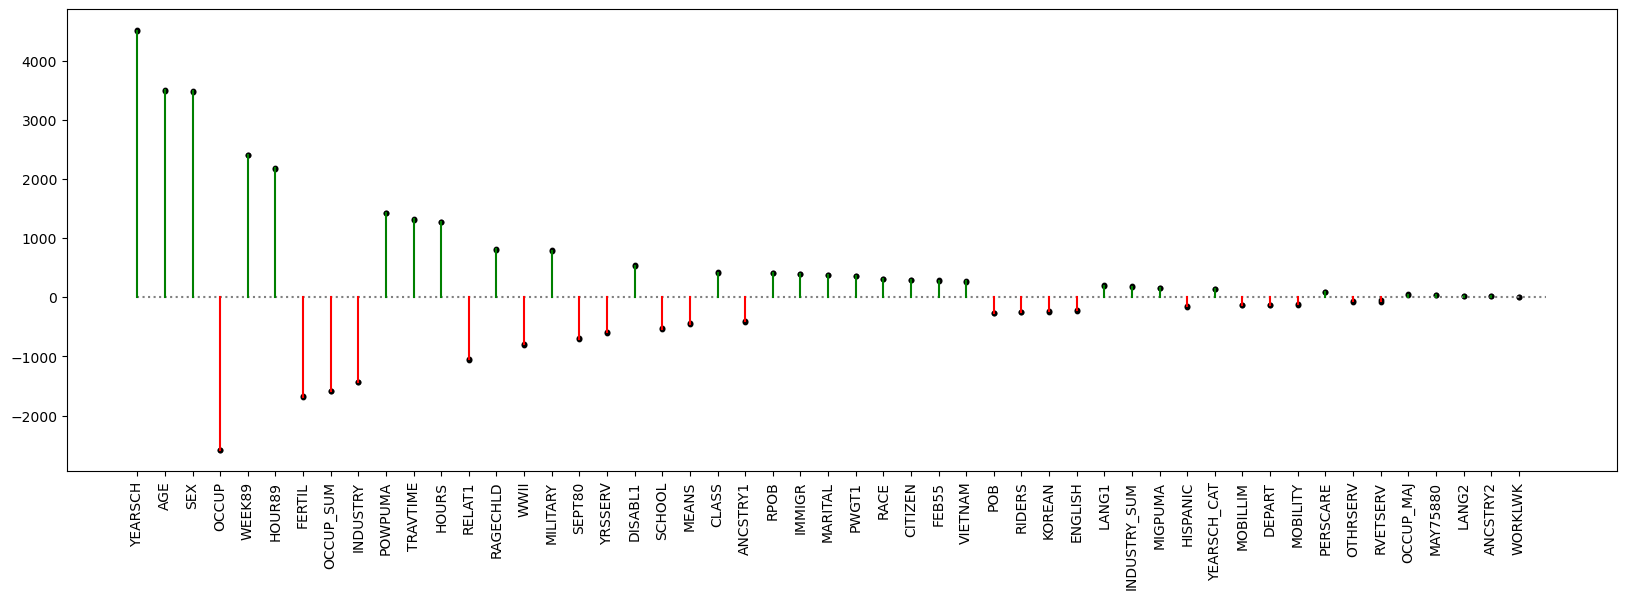



MOST IMPORTANT FEATURES

AGE        3503.33    Age
HOUR89     2180.72    Usual Hrs. Worked Per Week Last Yr. 1989
OCCUP      -2578.12   Occupation See Appendix I Occup.lst
SEX        3478.84    Sex
WEEK89     2415.13    Wks. Worked Last Yr. 1989
YEARSCH    4513.22    Ed. Attainment


LEAST IMPORTANT FEATURES

ANCSTRY2   17.67      Ancestry Second Entry See Appendix I Anc
LANG2      20.65      Language Spoken At Home See Appendix I L
MAY75880   39.45      Served May 1975 to August 1980
WORKLWK    6.57       Worked Last Week
OCCUP_MAJ  48.09      


In [110]:
fig, ax = plt.subplots(1,1,figsize=(20,6))

# yvals_ = reg.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals     = np.array([xvals_[i] for i in idx])
yvals     = np.array([yvals_[i] for i in idx])
yvals_err = np.array([yvals_err_[i] for i in idx])

plt.scatter(xvals, yvals - yvals_err, color="black", s=10)
plt.scatter(xvals, yvals + yvals_err, color="black", s=10)

plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
    
plt.xticks(rotation=90)
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(reg.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

### 2.4 More selective over columns

We can drop some of the less useful parameters to create a simpler model without losing too much accuracy

**Result** $$ \$9,700 $$

In [19]:
idx = np.argsort(np.abs(reg.coef_))[:25]

cols = [c for c in df_X.columns if c !=TARGET]
cols = [cols[i] for i in idx]

keep_cols = [c for c in df_X.columns if c not in cols ]
keep_cols

['AGE',
 'ANCSTRY1',
 'CLASS',
 'DISABL1',
 'FERTIL',
 'HOUR89',
 'HOURS',
 'IMMIGR',
 'INDUSTRY',
 'MARITAL',
 'MEANS',
 'MILITARY',
 'OCCUP',
 'POWPUMA',
 'RAGECHLD',
 'REARNING',
 'RELAT1',
 'RPOB',
 'SCHOOL',
 'SEPT80',
 'SEX',
 'TRAVTIME',
 'WEEK89',
 'WWII',
 'YEARSCH',
 'YRSSERV',
 'OCCUP_SUM']

In [45]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',
    
# #     'WORKLWK',
# #     'MILITARY',  
# #     'SEPT80',
# #     'WWII',
# #     'SCHOOL',
# #     'POWSTATE',
# #     'PWGT1',
# #     'RIDERS',
# #     'VIETNAM',
# #     'KOREAN',

# #     'OCCUP_JOB',
# #     'OCCUP_SUM',
# #     'OCCUP_MAJ',
# #     'INDUSTRY_CAT',
# #     'INDUSTRY_SUM',
# ]


In [20]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols, 
                        cat_cols    = [c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

reg = LinearRegression().fit(X_train, y_train)
_ = _regression_metrics(reg, X_test, y_test)

Rows          : 922769 Features: 27
Training data : 876631 
Test data     : 46138
Score                          : 0.36
Average Error                  : $9789
Classification (>$50,000) acc. : 92.62


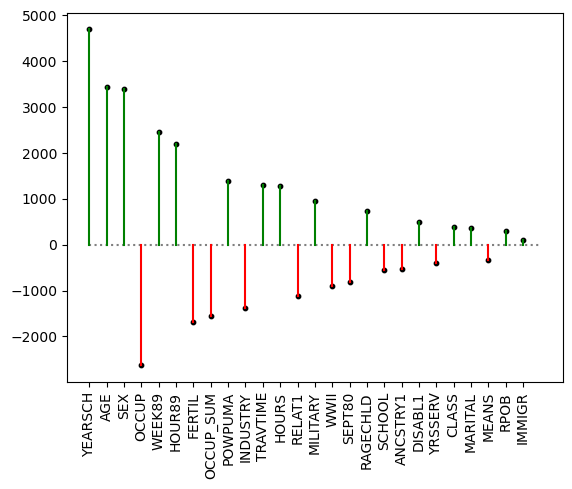



MOST IMPORTANT FEATURES

YEARSCH    4696.26    Ed. Attainment
AGE        3447.85    Age
SEX        3403.21    Sex
OCCUP      -2629.21   Occupation See Appendix I Occup.lst
WEEK89     2449.13    Wks. Worked Last Yr. 1989


LEAST IMPORTANT FEATURES

CLASS      380.88     Class of Worker
MARITAL    354.50     Marital Stat.
MEANS      -341.87    Means of Transportation to Work
RPOB       310.15     Place of Birth Recode
IMMIGR     98.80      Yr. of Entry


In [21]:

xvals_ = [c for c in df_X.columns if c !=TARGET]
yvals_ = reg.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx]
yvals = [yvals_[i] for i in idx]
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[-5:][::-1]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[::-1][-5:]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

### 2.5 Technique : Use dummy variables for cats

In linear regression we encode categorical features and fit a line to them; this does not really make sense

TODO : remove rare categories from high cardinality vars

**Result** : $$ \$9,100 $$

In [22]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART'
# ]
keep_cols

['AGE',
 'ANCSTRY1',
 'CLASS',
 'DISABL1',
 'FERTIL',
 'HOUR89',
 'HOURS',
 'IMMIGR',
 'INDUSTRY',
 'MARITAL',
 'MEANS',
 'MILITARY',
 'OCCUP',
 'POWPUMA',
 'RAGECHLD',
 'REARNING',
 'RELAT1',
 'RPOB',
 'SCHOOL',
 'SEPT80',
 'SEX',
 'TRAVTIME',
 'WEEK89',
 'WWII',
 'YEARSCH',
 'YRSSERV',
 'OCCUP_SUM']

['ANCSTRY1',
 'CLASS',
 'DISABL1',
 'IMMIGR',
 'INDUSTRY',
 'MARITAL',
 'MEANS',
 'MILITARY',
 'OCCUP',
 'POWPUMA',
 'RAGECHLD',
 'RELAT1',
 'RPOB',
 'SCHOOL',
 'SEPT80',
 'SEX',
 'WWII',
 'YEARSCH',
 'OCCUP_SUM']

In [30]:
dummy_cols = [k for k in keep_cols if k not in num_cols + ['OCCUP', 'ANCSTRY1', 'POWPUMA', 'RPOB','RAGECHLD']]
for k in dummy_cols:
    print(k, len(df[k].unique()))

CLASS 8
DISABL1 2
IMMIGR 11
INDUSTRY 243
MARITAL 5
MEANS 12
MILITARY 2
RELAT1 13
SCHOOL 3
SEPT80 2
SEX 2
WWII 2
YEARSCH 17
OCCUP_SUM 7


======= Fitting ========
======= Results ========
Score                          : 0.43
Average Error                  : $9189
Classification (>$50,000) acc. : 92.99


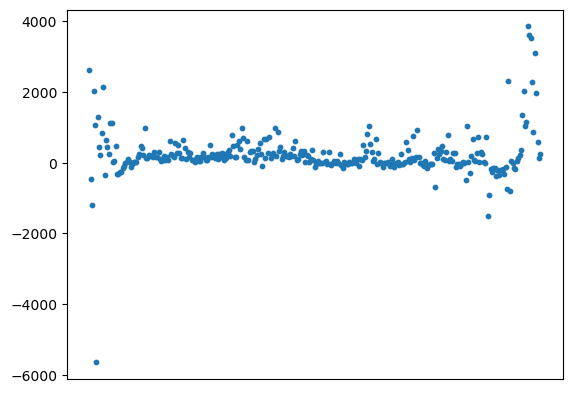

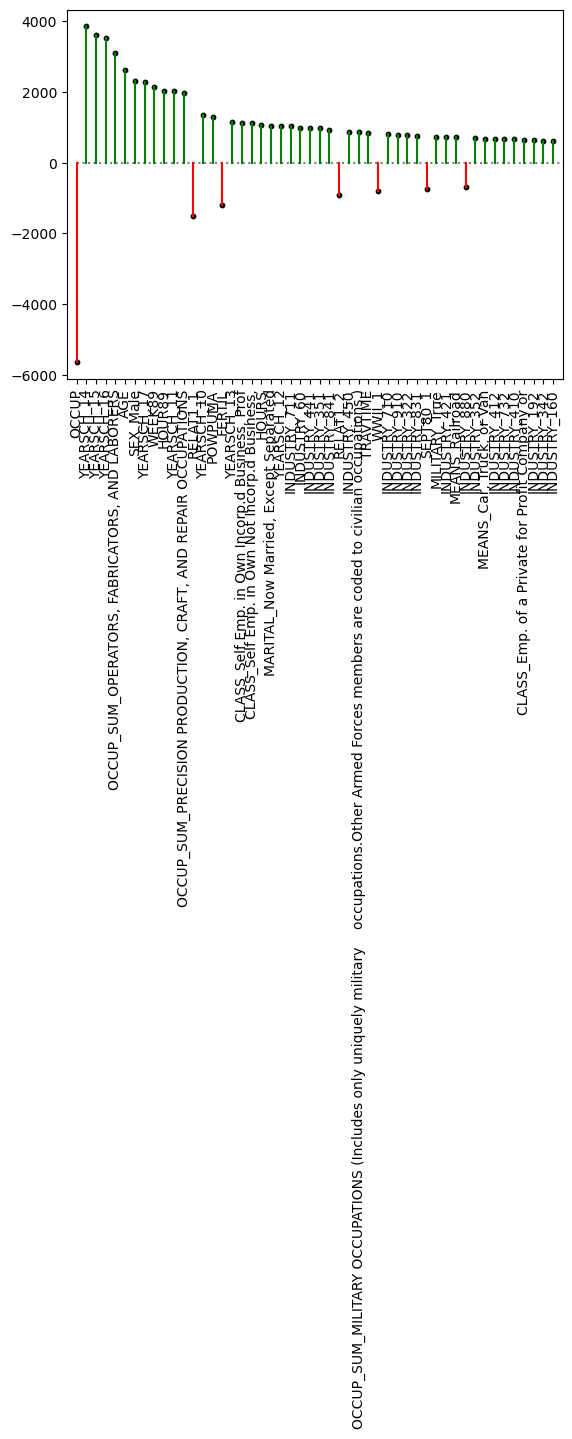



MOST IMPORTANT FEATURES

AGE        3447.85    Age
OCCUP      2189.45    Occupation See Appendix I Occup.lst
CLASS_Emp. of a Private for Profit Company or -2629.21   
DISABL1_2  3403.21    
IMMIGR_2   2449.13    
IMMIGR_4   4696.26    


LEAST IMPORTANT FEATURES



In [31]:

# dummy_cols = ['MARITAL', 
#               'OCCUP_SUM',
#               'INDUSTRY'
# #                'ENGLISH', 
# #                'RACE', 
# #                'OCCUP',
# #                'INDUSTRY'
#              ]



df_dummy = pd.get_dummies(df[keep_cols].iloc[:,:],
                          columns=dummy_cols, 
                          drop_first=True)

df_X, _ = _prepare_data(df_dummy, 
                        target      = TARGET, 
                        cols        = df_dummy.columns, 
                        cat_cols    = [c for c in df_dummy.columns if (c not in num_cols) and (c not in dummy_cols)], 
                        encode_cats = True,
                        verbose     = False)

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)

print("======= Fitting ========")
model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)



plt.scatter([c for c in df_dummy.columns if c !=TARGET], model.coef_, s=10)
plt.xticks([])
plt.show()

limit=50
xvals_ = [c for c in df_dummy.columns if c !=TARGET]
yvals_ = model.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx][:limit]
yvals = [yvals_[i] for i in idx][:limit]
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_dummy.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.xlim([-1, len(xvals)])
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(reg.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

(100000, 146)
======= Results ========
Score                          : -0.23
Average Error                  : $10674
Classification (>$50,000) acc. : 90.74


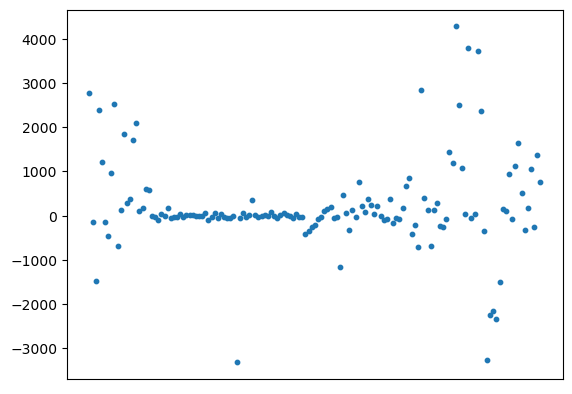

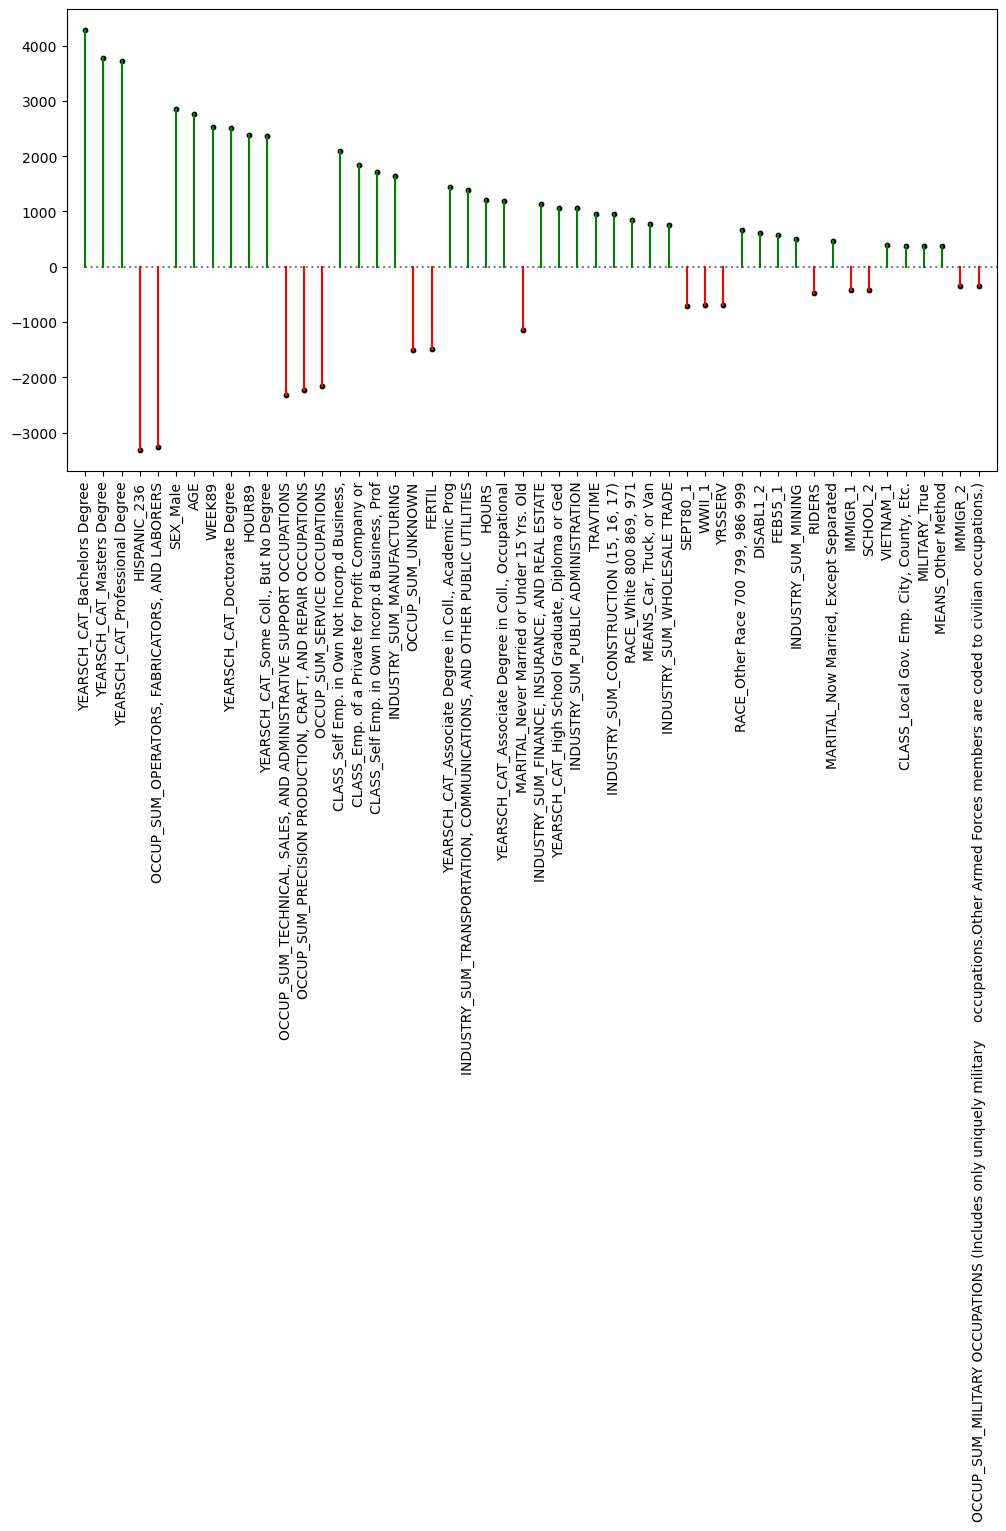



MOST IMPORTANT FEATURES

AGE        2766.45    Age
HOUR89     2389.25    Usual Hrs. Worked Per Week Last Yr. 1989
WEEK89     2526.65    Wks. Worked Last Yr. 1989
CLASS_Self Emp. in Own Not Incorp.d Business, 2101.85    
HISPANIC_236 -3317.66   
SEX_Male   2844.45    
YEARSCH_CAT_Bachelors Degree 4279.64    
YEARSCH_CAT_Doctorate Degree 2506.40    
YEARSCH_CAT_Masters Degree 3783.76    
YEARSCH_CAT_Professional Degree 3722.91    
YEARSCH_CAT_Some Coll., But No Degree 2356.48    
OCCUP_SUM_OPERATORS, FABRICATORS, AND LABORERS -3265.21   
OCCUP_SUM_PRECISION PRODUCTION, CRAFT, AND REPAIR OCCUPATIONS -2237.17   
OCCUP_SUM_SERVICE OCCUPATIONS -2152.99   
OCCUP_SUM_TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT OCCUPATIONS -2328.43   


LEAST IMPORTANT FEATURES

HISPANIC_1 -18.38     
HISPANIC_2 -21.10     
HISPANIC_4 32.90      
HISPANIC_199 -15.95     
HISPANIC_204 -39.55     
HISPANIC_209 -25.20     
HISPANIC_210 45.08      
HISPANIC_211 -33.44     
HISPANIC_212 20.76      
HISPANIC_213 1

In [32]:
drop_cols = [
     'OCCUP', 
     'INDUSTRY',
     'OCCUP_JOB',
     'OCCUP_MAJ',
     'INDUSTRY_CAT',
     'ANCSTRY1',
     'ANCSTRY2',
     'RELAT1',
     'RELAT2',
     'ASERVPER',
     'AVETS1',
    
     'POB',
     'RPOB',
     'MIGPUMA',
     'POWPUMA',
     'MIGSTATE',
     'POWSTATE',
     'RAGECHLD',
    
     'LANG1',
     'LANG2',
     'ENGLISH',
    
     'RELAT2',
     'SUBFAM1',
     'SUBFAM2',
     
     'RSPOUSE',  
     'RVETSERV', # duplicate the other military categories
     'YEARSCH',  # duplicate
]

keep_cols = [d for d in df.columns if d not in drop_cols]

df_dummy = pd.get_dummies(df[keep_cols].iloc[:100000,:],
                          columns=[c for c in keep_cols if c not in num_cols], 
                          drop_first=True)
print(df_dummy.shape)

df_X, _ = _prepare_data(df_dummy, 
                        target      = TARGET, 
                        cols        = df_dummy.columns, 
                        cat_cols    = [c for c in df_dummy.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)

model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)



plt.scatter([c for c in df_dummy.columns if c !=TARGET], model.coef_, s=10)
plt.xticks([])
plt.show()

limit=50
xvals_ = [c for c in df_dummy.columns if c !=TARGET]
yvals_ = model.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx][:limit]
yvals = [yvals_[i] for i in idx][:limit]

fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_dummy.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.xlim([-1, len(xvals)])
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((model.coef_ > 2000) | (model.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {model.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(model.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {model.coef_[i]:<10.2f} {description}")

## 2.2 Second Attempt : Different Model Choices

- All data, different models
- Benchmark Linear Regression

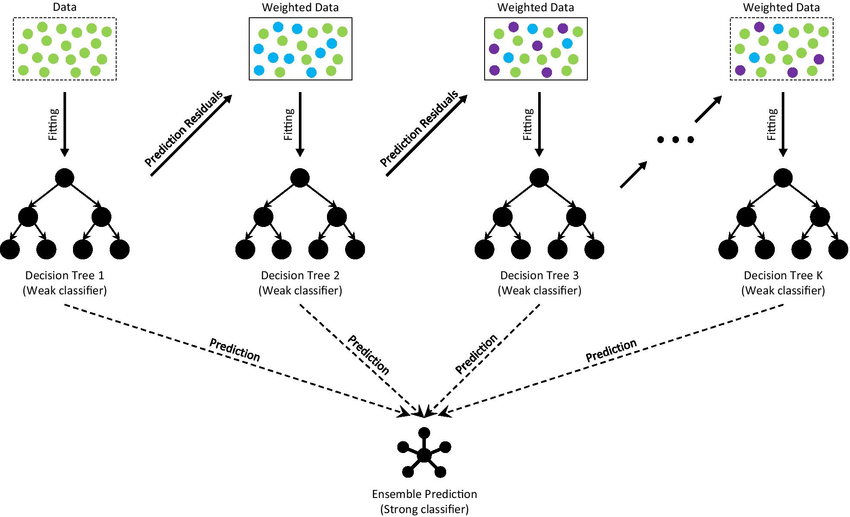

**Result** GBR : $$ \$8,700 $$

In [33]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = None, 
                        cat_cols    = [c for c in df.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)

Cardinalities
ANCSTRY1                  : 255
ANCSTRY2                  : 192
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
ENGLISH                   : 5
FEB55                     : 2
HISPANIC                  : 56
IMMIGR                    : 11
INDUSTRY                  : 243
KOREAN                    : 2
LANG1                     : 2
LANG2                     : 213
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MIGPUMA                   : 109
MIGSTATE                  : 52
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OCCUP                     : 504
OTHRSERV                  : 2
PERSCARE                  : 2
POB                       : 267
POWPUMA                   : 108
POWSTATE                  : 52
RACE                      : 3
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
RVETSERV                  : 12
SC

In [34]:
# benchmark
model = LinearRegression().fit(X_train, y_train)
print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.37
Average Error                  : $9696
Classification (>$50,000) acc. : 92.89


In [35]:
# Try and gradient boosted tree algorithm...
model = GradientBoostingRegressor(n_estimators  =100, 
                                  learning_rate =0.1,
#                                 max_depth     =5, 
                                  random_state  = 0).fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.46
Average Error                  : $8700
Classification (>$50,000) acc. : 93.39


Gradient boosted decision trees

In [39]:
print("======= Feature Importance ========")

importance = {}
for a,b in zip(df_X.drop(TARGET, axis=1).columns, model.feature_importances_):
    importance[a] = b

run_total=0.0
for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
    desc = describe_feature(a)
    run_total += b
    print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")

======= Feature Importance ========
YEARSCH    - 0.207 - 0.21 - Ed. Attainment
OCCUP      - 0.182 - 0.39 - Occupation See Appendix I Occup.lst
AGE        - 0.121 - 0.51 - Age
HOUR89     - 0.088 - 0.60 - Usual Hrs. Worked Per Week Last Yr. 1989
RELAT1     - 0.073 - 0.67 - Rel. or Not Related or Grp. Qtrs.
SEX        - 0.057 - 0.73 - Sex
WEEK89     - 0.054 - 0.78 - Wks. Worked Last Yr. 1989
RAGECHLD   - 0.051 - 0.83 - Presence and Age of Own Chld.
FERTIL     - 0.037 - 0.87 - No. of Chld. Ever Born
INDUSTRY   - 0.027 - 0.90 - Ind. See Appendix I Ind..lst
HOURS      - 0.019 - 0.92 - Hrs. Worked Last Week
POWPUMA    - 0.016 - 0.93 - Place of Work Puma State Dependent
TRAVTIME   - 0.011 - 0.94 - Travel Time to Work
CLASS      - 0.009 - 0.95 - Class of Worker
ANCSTRY1   - 0.007 - 0.96 - Ancestry First Entry See Appendix I Ance
MIGSTATE   - 0.007 - 0.97 - Migration State or Foreign Country Code
MARITAL    - 0.006 - 0.97 - Marital Stat.
INDUSTRY_SUM - 0.005 - 0.98 - 
OCCUP_MAJ  - 0.004 - 0.98 -

Let's try a few more models

In [40]:
models = []
models.append(('LR',   LinearRegression()))
models.append(('GBR',  GradientBoostingRegressor()))
models.append(('DTR',  DecisionTreeRegressor()))
models.append(('RFR',  RandomForestRegressor()))


for name, model in models:
    model.fit(X_train[:100000,:], y_train[:100000])
    print("======= Results ========")
    _ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.37
Average Error                  : $9681
Classification (>$50,000) acc. : 92.88
======= Results ========
Score                          : 0.46
Average Error                  : $8709
Classification (>$50,000) acc. : 93.33
======= Results ========
Score                          : -0.14
Average Error                  : $12364
Classification (>$50,000) acc. : 89.63
======= Results ========
Score                          : 0.46
Average Error                  : $8714
Classification (>$50,000) acc. : 93.03


In [45]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',
    
# #     'WORKLWK',
# #     'MILITARY',  
# #     'SEPT80',
# #     'WWII',
# #     'SCHOOL',
# #     'POWSTATE',
# #     'PWGT1',
# #     'RIDERS',
# #     'VIETNAM',
# #     'KOREAN',

# #     'OCCUP_JOB',
# #     'OCCUP_SUM',
# #     'OCCUP_MAJ',
# #     'INDUSTRY_CAT',
# #     'INDUSTRY_SUM',
# ]

keep_cols

['AGE',
 'CITIZEN',
 'CLASS',
 'DEPART',
 'DISABL1',
 'FEB55',
 'FERTIL',
 'HISPANIC',
 'HOUR89',
 'HOURS',
 'IMMIGR',
 'KOREAN',
 'MARITAL',
 'MAY75880',
 'MEANS',
 'MILITARY',
 'MOBILITY',
 'MOBILLIM',
 'OTHRSERV',
 'PERSCARE',
 'PWGT1',
 'RACE',
 'REARNING',
 'RIDERS',
 'SCHOOL',
 'SEPT80',
 'SEX',
 'TRAVTIME',
 'VIETNAM',
 'WEEK89',
 'WORKLWK',
 'WWII',
 'YRSSERV',
 'YEARSCH_CAT',
 'OCCUP_SUM',
 'INDUSTRY_SUM']

In [41]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols, 
                        cat_cols    = [c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')
X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET)

Cardinalities
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
FEB55                     : 2
HISPANIC                  : 56
IMMIGR                    : 11
KOREAN                    : 2
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OTHRSERV                  : 2
PERSCARE                  : 2
RACE                      : 3
SCHOOL                    : 3
SEPT80                    : 2
SEX                       : 2
VIETNAM                   : 2
WORKLWK                   : 2
WWII                      : 2
YEARSCH_CAT               : 17
OCCUP_SUM                 : 7
INDUSTRY_SUM              : 14




In [42]:
model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.28
Average Error                  : $10492
Classification (>$50,000) acc. : 92.38


In [43]:
model = GradientBoostingRegressor(n_estimators    =100, 
                                  learning_rate   =1.0,
                                  random_state    = 0).fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.46
Average Error                  : $8862
Classification (>$50,000) acc. : 93.14


In [44]:
importance = {}
for a,b in zip(df_X.drop(TARGET, axis=1).columns, model.feature_importances_):
    importance[a] = b

run_total=0.0
for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
    desc = describe_feature(a)
    run_total += b
    print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")

OCCUP_SUM  - 0.232 - 0.23 - 
AGE        - 0.155 - 0.39 - Age
FERTIL     - 0.130 - 0.52 - No. of Chld. Ever Born
SEX        - 0.121 - 0.64 - Sex
YEARSCH_CAT - 0.103 - 0.74 - 
HOUR89     - 0.088 - 0.83 - Usual Hrs. Worked Per Week Last Yr. 1989
WEEK89     - 0.049 - 0.88 - Wks. Worked Last Yr. 1989
INDUSTRY_SUM - 0.034 - 0.91 - 
PWGT1      - 0.020 - 0.93 - Pers. Wgt
TRAVTIME   - 0.017 - 0.95 - Travel Time to Work
CLASS      - 0.016 - 0.96 - Class of Worker
HOURS      - 0.008 - 0.97 - Hrs. Worked Last Week
MEANS      - 0.005 - 0.98 - Means of Transportation to Work
MARITAL    - 0.004 - 0.98 - Marital Stat.
RACE       - 0.003 - 0.98 - Recoded Detailed Race Code Appendix C Ra
DEPART     - 0.003 - 0.99 - Time of Departure for Work Hour and Minu
DISABL1    - 0.002 - 0.99 - Work Limitation Stat.
RIDERS     - 0.002 - 0.99 - Vehicle Occupancy
YRSSERV    - 0.002 - 0.99 - Yrs. of Active Duty Military Srvc.
CITIZEN    - 0.002 - 1.00 - Citizenship
IMMIGR     - 0.001 - 1.00 - Yr. of Entry
HISPANIC   -

## 2.3 Third Attempt

So far, linear regression has given a good benchmark; and is quick to train; but other types of models perform significantly better.

- We use a selected group of features
- We use boosted decision trees; as these are superior to linear regression

**Best Result** : $$ \$8,500 $$


### 2.3.1 Automated Feature Selection

In [56]:
keep_cols_0 = [
    'REARNING',
    'OCCUP']

# test_cols=[
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',    
#     'WORKLWK',
#     'MILITARY',  
#     'SEPT80',
#     'WWII',
#     'SCHOOL',
#     'POWSTATE',
#     'PWGT1',
#     'RIDERS',
#     'VIETNAM',
#     'KOREAN',
#     'multilingual'
# ]

test_cols = [d for d in df.columns if d not in keep_cols_0]

keep_cols_1 = keep_cols_0

df_2 = reduce_cardinality(df, 'OCCUP', 700)

baseline = 0.0
for t in test_cols:
    print("="*80)
    print("Testing addition of ", t)
    
    keep_cols_1 += [t]
    print("Features :", keep_cols_1)
    
    tmp = [c for c in keep_cols_1 if c != TARGET]
    tmp = [True if c not in num_cols else False for c in tmp]
    
#     tmp = [c for c in keep_cols_1 if c != TARGET]
#     tmp = [True if c not in num_cols else False for c in tmp]
    
#     gb = df.groupby('OCCUP').count().sort_values('AGE')['AGE']
#     low_occup_codes = set(list(gb[gb < 100].index))
#     repl = min(low_occup_codes)

#     df_2 = df.copy()
#     # df_2 = df_2[df['OCCUP'].apply(lambda x: x not in low_occup_codes)]
#     df_2['OCCUP'] = df['OCCUP'].apply(lambda x: repl if x in low_occup_codes else x)
    
    df_X, _ = _prepare_data(df_2, 
                            target      = TARGET, 
                            cols        = keep_cols_1, 
                            cat_cols    = [c for c in keep_cols_1 if c not in num_cols], 
                            encode_cats = True,
                            verbose     = False)

    X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET)

    model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
#                                  max_depth=6, 
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)

    _regression_metrics(model, X_test, y_test)
    
    score = model.score(X_test, y_test)
    if (score - baseline) > 0.001:
        # keep
        print("Keep!")
        baseline = score
    else:
        # reject
        print("Reject!")
        keep_cols_1 = keep_cols_1[:-1]

Old cardinality 504
New cardinality 222
Testing addition of  AGE
Features : ['REARNING', 'OCCUP', 'AGE']
======= Results ========
Score                          : 0.31
Average Error                  : $10150
Classification (>$50,000) acc. : 92.72
Keep!
Testing addition of  ANCSTRY1
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1']
======= Results ========
Score                          : 0.33
Average Error                  : $10023
Classification (>$50,000) acc. : 92.74
Keep!
Testing addition of  ANCSTRY2
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'ANCSTRY2']
======= Results ========
Score                          : 0.32
Average Error                  : $10022
Classification (>$50,000) acc. : 92.87
Reject!
Testing addition of  CITIZEN
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'CITIZEN']
======= Results ========
Score                          : 0.33
Average Error                  : $10084
Classification (>$50,000) acc. : 92.64
Keep!
Testing addition of  CLASS
Featur

======= Results ========
Score                          : 0.46
Average Error                  : $8668
Classification (>$50,000) acc. : 93.16
Reject!
Testing addition of  MIGSTATE
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'CITIZEN', 'CLASS', 'DEPART', 'DISABL1', 'ENGLISH', 'FEB55', 'FERTIL', 'HOUR89', 'HOURS', 'INDUSTRY', 'LANG1', 'MIGSTATE']
======= Results ========
Score                          : 0.48
Average Error                  : $8470
Classification (>$50,000) acc. : 93.10
Keep!
Testing addition of  MILITARY
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'CITIZEN', 'CLASS', 'DEPART', 'DISABL1', 'ENGLISH', 'FEB55', 'FERTIL', 'HOUR89', 'HOURS', 'INDUSTRY', 'LANG1', 'MIGSTATE', 'MILITARY']
======= Results ========
Score                          : 0.48
Average Error                  : $8423
Classification (>$50,000) acc. : 93.30
Keep!
Testing addition of  MOBILITY
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'CITIZEN', 'CLASS', 'DEPART', 'DISABL1', 'ENGLISH', '

ValueError: Categorical feature at index 18 is expected to have a cardinality <= 255

['REARNING', 'OCCUP', 'INDUSTRY']


======= Results ========
Score                          : 0.29
Average Error                  : $9290
Classification (>$50,000) acc. : 95.15
['REARNING', 'OCCUP', 'INDUSTRY', 'RACE']


======= Results ========
Score                          : 0.31
Average Error                  : $9107
Classification (>$50,000) acc. : 94.98
['REARNING', 'OCCUP', 'INDUSTRY', 'RACE', 'SEX']


======= Results ========
Score                          : 0.34
Average Error                  : $8866
Classification (>$50,000) acc. : 95.15
['REARNING', 'OCCUP', 'INDUSTRY', 'RACE', 'SEX', 'HOURS']


======= Results ========
Score                          : 0.36
Average Error                  : $8691
Classification (>$50,000) acc. : 95.33
['REARNING', 'OCCUP', 'INDUSTRY', 'RACE', 'SEX', 'HOURS', 'AGE']


======= Results ========
Score                          : 0.42
Average Error                  : $8081
Classification (>$50,000) acc. : 95.38
['REARNING', 'OCCUP', 'INDUSTRY', 'RA

ValueError: categorical_features set as a boolean mask must have shape (n_features,), got: (17,)

In [531]:
keep_cols_1

['REARNING',
 'OCCUP',
 'INDUSTRY',
 'RACE',
 'SEX',
 'HOURS',
 'AGE',
 'WEEK89',
 'MARITAL',
 'ENGLISH',
 'YRSSERV',
 'YEARSCH',
 'CLASS',
 'SEPT80',
 'RIDERS',
 'VIETNAM',
 'KOREAN',
 'multilingual']

['REARNING',
 'OCCUP',
 'INDUSTRY',
 'RACE',
 'SEX',
 'HOURS',
 'AGE',
 'WEEK89',
 'MARITAL',
 'ENGLISH',
 'YEARSCH',
 'CLASS',
 'DEPART',
 'WORKLWK',
 'MILITARY',
 'SCHOOL',
 'RIDERS']

In [532]:
[t for t in test_cols if t not in keep_cols_1]

['FERTIL',
 'MEANS',
 'CITIZEN',
 'DEPART',
 'WORKLWK',
 'MILITARY',
 'WWII',
 'SCHOOL',
 'POWSTATE',
 'PWGT1']

### 2.3.1 Gradient Boosted Trees with Categorical Variables

We have introduced the same problem with cat variables to GBDTs; even though these models are naturally less sensitive.

We can use **histogram** based trees to improve on this.

Due to complexity, the maximum cardinality for histogram based trees is 255, which is less than some of our features. We thus need to reduce the cardinality. We can do this by gathering all uncommon classes into a single "other" category.

**Result** : $$ \$8,500 $$

In [58]:
def reduce_cardinality(df, feature='OCCUP', group_below=700):
    
    gb = df.groupby(feature).count().sort_values('AGE')['AGE']
    
    print(f"Old cardinality {gb.shape[0]}")

    low_occup_codes = set(list(gb[gb < group_below].index))
    repl = min(low_occup_codes)

    df_2 = df.copy()
    df_2[feature] = df[feature].apply(lambda x: repl if x in low_occup_codes else x)
    
    print(f"New cardinality {len(df_2[feature].unique())}")
    
    return df_2

In [59]:
df_2 = reduce_cardinality(df, 'OCCUP', 700 )

Old cardinality 504
New cardinality 222


In [60]:
cat_cols = [c for c in keep_cols if c not in num_cols]

tmp = [c for c in keep_cols if c != TARGET]
tmp = [True if c not in num_cols else False for c in tmp]

df_X, lecs = _prepare_data(df_2, 
                            target      = TARGET, 
                            cols        = keep_cols, 
                            cat_cols    = cat_cols, # [c for c in df_2.columns if c not in num_cols],# 
                            encode_cats = True,
                            verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)

Cardinalities
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
FEB55                     : 2
HISPANIC                  : 56
IMMIGR                    : 11
KOREAN                    : 2
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OTHRSERV                  : 2
PERSCARE                  : 2
RACE                      : 3
SCHOOL                    : 3
SEPT80                    : 2
SEX                       : 2
VIETNAM                   : 2
WORKLWK                   : 2
WWII                      : 2
YEARSCH_CAT               : 17
OCCUP_SUM                 : 7
INDUSTRY_SUM              : 14




Cardinalities
OCCUP                     : 222
INDUSTRY                  : 243
RACE                      : 3
SEX                       : 2
MARITAL                   : 5
ENGLISH                   : 5
MEANS                     : 12
CITIZEN                   : 2
YEARSCH                   : 17
CLASS                     : 8




In [61]:
model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
#                                  max_depth=6, 
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)

In [62]:
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.49
Average Error                  : $8557
Classification (>$50,000) acc. : 93.09


In [63]:
# train N times
results = []

for i in range(10):
    X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                   target  = TARGET, 
                                                   scaler  = None, 
                                                   shuffle = True)
    
    model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)
    results += [_regression_metrics(model, X_test, y_test)]

err = [r['mean_abs_err'] for r in results]
print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

Score                          : 0.48
Average Error                  : $8444
Classification (>$50,000) acc. : 93.19
Score                          : 0.48
Average Error                  : $8538
Classification (>$50,000) acc. : 92.88
Score                          : 0.48
Average Error                  : $8531
Classification (>$50,000) acc. : 93.11
Score                          : 0.48
Average Error                  : $8519
Classification (>$50,000) acc. : 93.29
Score                          : 0.48
Average Error                  : $8569
Classification (>$50,000) acc. : 93.06
Score                          : 0.48
Average Error                  : $8412
Classification (>$50,000) acc. : 93.20
Score                          : 0.49
Average Error                  : $8473
Classification (>$50,000) acc. : 93.28
Score                          : 0.49
Average Error                  : $8394
Classification (>$50,000) acc. : 93.33
Score                          : 0.48
Average Error                  : $

##  2.4 Model Tuning

Now we have selected a good model; we can tune the performance by adjusting the **hyperparameters**

**Best Result** : $$ \$8,400 $$

In [53]:
# baseline = no tuning
model = HistGradientBoostingRegressor(max_bins=255,
                                      categorical_features=tmp).fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.48
Average Error                  : $8536
Classification (>$50,000) acc. : 93.09


In [65]:
results = []

for lr in np.linspace(0.005,0.25,25):
    print(lr)
    model = HistGradientBoostingRegressor( 
                                     learning_rate=lr,
                                     max_bins=255,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res] #model.score(X_test, y_test)]

0.005
Score                          : 0.24
Average Error                  : $11102
Classification (>$50,000) acc. : 92.49
0.015208333333333334
Score                          : 0.40
Average Error                  : $9580
Classification (>$50,000) acc. : 93.03
0.025416666666666667
Score                          : 0.44
Average Error                  : $9052
Classification (>$50,000) acc. : 93.16
0.035625
Score                          : 0.46
Average Error                  : $8825
Classification (>$50,000) acc. : 93.26
0.04583333333333333
Score                          : 0.47
Average Error                  : $8706
Classification (>$50,000) acc. : 93.20
0.05604166666666666
Score                          : 0.48
Average Error                  : $8638
Classification (>$50,000) acc. : 93.19
0.06625
Score                          : 0.48
Average Error                  : $8589
Classification (>$50,000) acc. : 93.18
0.07645833333333334
Score                          : 0.48
Average Error           

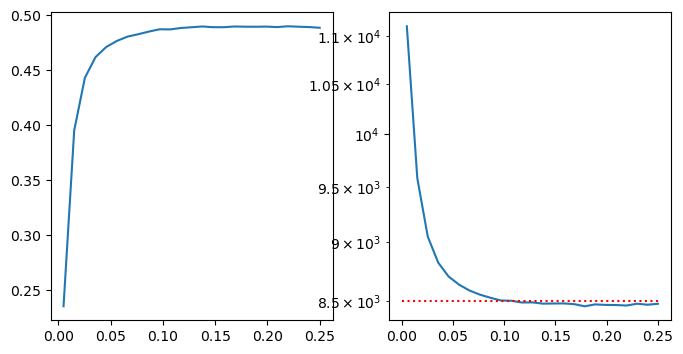

In [74]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(np.linspace(0.005,0.25,25), [r['score'] for r in results])
ax[1].plot(np.linspace(0.005,0.25,25), [r['mean_abs_err'] for r in results])
ax[1].plot([0,0.25],[8500,8500], color='r', ls=":")
plt.yscale('log')

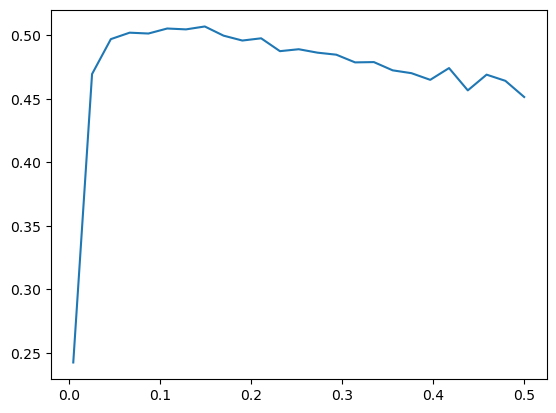

In [75]:
results = []

for v in np.linspace(10,250,25):
    print(v)
    model = HistGradientBoostingRegressor( 
                                     learning_rate       =0.25,
                                     max_bins            =255,
                                     max_iter            = int(v),
                                     categorical_features=tmp,
                                     random_state        =0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res]

10.0
Score                          : 0.44
Average Error                  : $9041
Classification (>$50,000) acc. : 93.19
20.0
Score                          : 0.47
Average Error                  : $8720
Classification (>$50,000) acc. : 93.17
30.0
Score                          : 0.48
Average Error                  : $8600
Classification (>$50,000) acc. : 93.18
40.0
Score                          : 0.48
Average Error                  : $8548
Classification (>$50,000) acc. : 93.17
50.0
Score                          : 0.48
Average Error                  : $8529
Classification (>$50,000) acc. : 93.15
60.0
Score                          : 0.49
Average Error                  : $8512
Classification (>$50,000) acc. : 93.15
70.0
Score                          : 0.49
Average Error                  : $8502
Classification (>$50,000) acc. : 93.16
80.0
Score                          : 0.49
Average Error                  : $8491
Classification (>$50,000) acc. : 93.15
90.0
Score                      

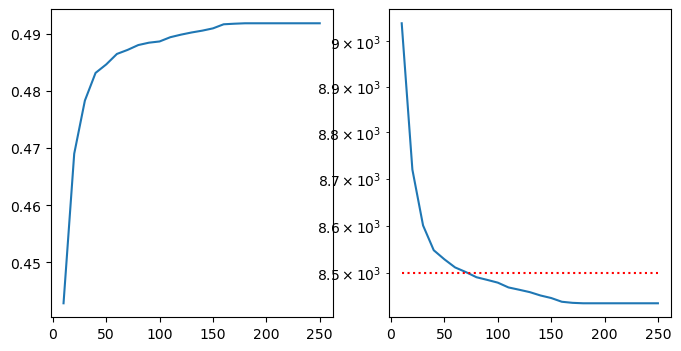

In [78]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(np.linspace(10,250,25), [r['score'] for r in results])
ax[1].plot(np.linspace(10,250,25), [r['mean_abs_err'] for r in results])
ax[1].plot([10,250],[8500,8500], color='r', ls=":")
plt.yscale('log')

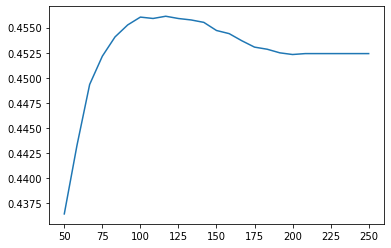

In [81]:
results = []

for v in range(1,10,1):
    print(v)
    model = HistGradientBoostingRegressor( 
                                     learning_rate = 0.25,
                                     max_bins      = 255,
                                     max_depth     = v,
                                     max_iter      = 200,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res]

1
Score                          : 0.42
Average Error                  : $9333
Classification (>$50,000) acc. : 92.95
2
Score                          : 0.45
Average Error                  : $8915
Classification (>$50,000) acc. : 93.10
3
Score                          : 0.48
Average Error                  : $8596
Classification (>$50,000) acc. : 93.21
4
Score                          : 0.49
Average Error                  : $8489
Classification (>$50,000) acc. : 93.21
5
Score                          : 0.49
Average Error                  : $8423
Classification (>$50,000) acc. : 93.21
6
Score                          : 0.49
Average Error                  : $8421
Classification (>$50,000) acc. : 93.20
7
Score                          : 0.49
Average Error                  : $8413
Classification (>$50,000) acc. : 93.13
8
Score                          : 0.50
Average Error                  : $8410
Classification (>$50,000) acc. : 93.21
9
Score                          : 0.49
Average Error   

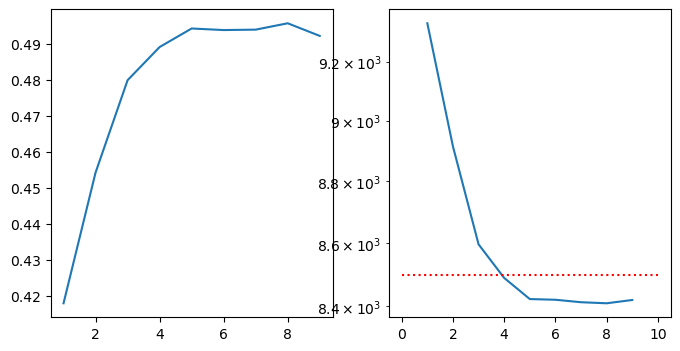

In [82]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(1,10,1), [r['score'] for r in results])
ax[1].plot(range(1,10,1), [r['mean_abs_err'] for r in results])
ax[1].plot([0,10],[8500,8500], color='r', ls=":")
plt.yscale('log')

# Stage 3 :  Model Testing

- We provided some basic metrics, but can we look deeper
- Use our best model and best parameter set (after tuning)

In [83]:
import lime
import lime.lime_tabular

In [84]:
model = HistGradientBoostingRegressor( 
                                     learning_rate= 0.25,
                                     max_bins     = 255,
                                     max_depth    = 9,
                                     max_iter     = 200,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.49
Average Error                  : $8420
Classification (>$50,000) acc. : 93.17


In [86]:
feature_names = [x for x in list(df_X.columns) if x!=TARGET]

explainer = lime.lime_tabular.LimeTabularExplainer(
   X_train, 
   feature_names       = feature_names, 
   categorical_features= [i for i, x in enumerate(feature_names) if x in cats], 
   verbose             = True, 
   mode                = 'regression')

In [89]:
i = 0

xi,yi = X_test[i], y_test[i]
exp   = explainer.explain_instance(xi, 
                                 model.predict, 
                                 num_features=8)
exp.show_in_notebook(show_table=True)

Intercept 21706.931085369604
Prediction_local [16639.17155205]
Right: 19398.84576977884


## 3.2 Variational Testing

In [430]:
# extract a dictionary input
features = [c for c in df_2.columns if c != TARGET] # [c for c in keep_cols if c != TARGET]
assert len(features) == X_train.shape[1]
xi = {k:i for k,i in zip(features, X_train[4])}

xi_inv = xi.copy()
for k,v in xi.items():
    if k in lecs:
        xi_inv[k] = lecs[k].inverse_transform([int(v)])[0]
xi_inv

{'AGE': 36.0,
 'ANCSTRY1': 900.0,
 'ANCSTRY2': 999.0,
 'CITIZEN': 1.0,
 'CLASS': 'Emp. of a Private Not for Profit, Tax Ex',
 'DEPART': 600.0,
 'DISABL1': 2.0,
 'ENGLISH': 3.0,
 'FEB55': 0.0,
 'FERTIL': 5.0,
 'HISPANIC': 0.0,
 'HOUR89': 37.0,
 'HOURS': 37.0,
 'IMMIGR': 0.0,
 'INDUSTRY': 842.0,
 'KOREAN': 0.0,
 'MARITAL': 'Now Married, Except Separated',
 'MAY75880': 0.0,
 'MEANS': 'Car, Truck, or Van',
 'MIGPUMA': 1000.0,
 'MIGSTATE': 'Missouri',
 'MILITARY': 0.0,
 'MOBILITY': 2.0,
 'MOBILLIM': 2.0,
 'OCCUP': 156.0,
 'OTHRSERV': 0.0,
 'PERSCARE': 2.0,
 'POB': 'Alabama',
 'POWPUMA': 1000.0,
 'POWSTATE': 'Missouri',
 'PWGT1': 136.0,
 'RACE': 'Black 870 934, 972',
 'RAGECHLD': 'With Own Chld. 6 to 17 Yrs. Only',
 'RELAT1': 1.0,
 'RIDERS': 1.0,
 'RPOB': 'South',
 'RVETSERV': 0.0,
 'SCHOOL': 1.0,
 'SEPT80': 0.0,
 'SEX': 'Female',
 'TRAVTIME': 30.0,
 'VIETNAM': 0.0,
 'WEEK89': 50.0,
 'WORKLWK': 1.0,
 'WWII': 0.0,
 'YEARSCH': 11.0,
 'YRSSERV': 0.0,
 'YEARSCH_CAT': 'Some Coll., But No Degree',

{'OCCUP': 17.0,
 'INDUSTRY': 641.0,
 'RACE': 'White 800 869, 971',
 'SEX': 0.0,
 'HOURS': 99.0,
 'AGE': 62.0,
 'FERTIL': 0.0,
 'WEEK89': 52.0,
 'MARITAL': 0.0,
 'ENGLISH': 2.0,
 'YRSSERV': 0.0,
 'MEANS': 1.0,
 'CITIZEN': 1.0,
 'YEARSCH': 15.0,
 'CLASS': 6.0,
 'DEPART': 530.0}

In [431]:
def _predict_from_dict(model, xi, encoders: dict, scaler=None):
    
    categorical_vars = list(encoders.keys())
    
    for feature in categorical_vars:
        xi[feature] = encoders[feature].transform(np.array(xi[feature]).reshape(1,))[0]
    
    labels = list(xi.keys())
    
    if scaler:
        xi = scaler.transform(pd.DataFrame(np.array(list(xi.values())).reshape(1,-1), 
                                           columns=xi.keys()))  
    else:
        xi = np.array(list(xi.values())).reshape(1,-1)
    
#     xi = pd.DataFrame(xi, columns=labels)
    
    ri = model.predict(xi)

    return ri

In [372]:
xi = {'OCCUP': 17.0,
     'INDUSTRY': 641.0,
     'RACE': 'White 800 869, 971',
     'SEX': 0.0,
     'HOURS': 99.0,
     'AGE': 62.0,
     'FERTIL': 0.0,
     'WEEK89': 52.0,
     'MARITAL': 0.0,
     'ENGLISH': 2.0,
     'YRSSERV': 0.0,
     'MEANS': 1.0,
     'CITIZEN': 1.0,
     'YEARSCH': 15.0,
     'CLASS': 6.0,
     'DEPART': 530.0}

_predict_from_dict(model, xi.copy(), lecs)

array([40031.9578801])

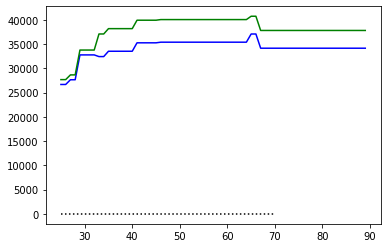

In [378]:
xi = {'OCCUP': 17.0,
     'INDUSTRY': 641.0,
     'RACE' : 'White 800 869, 971',
     'SEX': 0.0,
     'HOURS': 99.0,
     'AGE': 62.0,
     'FERTIL': 0.0,
     'WEEK89': 52.0,
     'MARITAL': 0.0,
     'ENGLISH': 2.0,
     'YRSSERV': 0.0,
     'MEANS': 1.0,
     'CITIZEN': 1.0,
     'YEARSCH': 15.0,
     'CLASS': 6.0,
     'DEPART': 530.0}

res = []
for i in range(25,90,1):
    xi['AGE'] = i
    xi['SEX'] = 1 # female
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(25,90,1), res, color="b")

res = []
for i in range(25,90,1):
    xi['AGE'] = i
    xi['SEX'] = 0 # male
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(25,90,1), res, color="g")

plt.plot([25,70], [0.5,0.5], color="black", ls=":")
# plt.ylim([0.25,0.75])

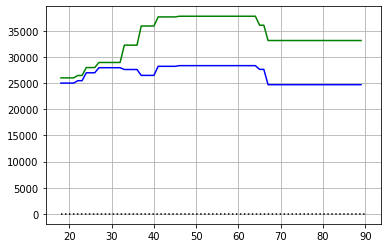

In [390]:
xi = {'OCCUP'  : 8.0,
     'INDUSTRY': 641.0,
     'RACE'    : 'White 800 869, 971',
     'SEX'     : 0.0,
     'HOURS'   : 99.0,
     'AGE'     : 50.0,
     'FERTIL'  : 0.0,
     'WEEK89'  : 52.0,
     'MARITAL' : 0.0,
     'ENGLISH' : 2.0,
     'YRSSERV' : 0.0,
     'MEANS'   : 1.0,
     'CITIZEN' : 1.0,
     'YEARSCH' : 15.0,
     'CLASS'   : 6.0,
     'DEPART'  : 530.0}

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 1 # female
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="b")

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 0 # male
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="g")

plt.plot([18,90], [0.5,0.5], color="black", ls=":")
plt.grid()
# plt.ylim([0.25,0.75])

In [385]:
df_X['OCCUP'].unique()

array([115, 154, 109,  29, 186,  73,  39,  66,  95,  35, 185, 188, 170,
       189,   0,  77,  57,   1,  10,  64, 101,  72,  25,  58,  96, 145,
        36,  59,  18, 199,  85, 155, 161, 117,  27,  68, 136, 114,  20,
        38,  42,   7,  12,  75,  49,  31,  45,  71,  44,   5,  89, 103,
        55, 156, 121, 194, 182,   4, 158,  51,  43, 175, 183,  74,  70,
       195, 149,  46,  90,  87,  28,  14,  60,  37,  76,  79, 164, 152,
       169, 162, 126,  97, 124,  19,   2,  34,  11,  98,  78, 200, 143,
        61,   3, 165,  33, 193, 197, 138, 184,  65, 159, 111,  50, 181,
        91, 112, 106, 192,  81, 191, 102,  52, 132, 198, 196, 122, 128,
        86,  99, 139,  26, 176,  84, 118,  80, 177,  83, 123,  40, 150,
       129, 105, 110, 130,  15, 151, 172, 146, 160, 179, 178, 116, 144,
         9, 140,  54,   6, 120,  22,  62,  53,  63,  17, 168, 100, 131,
        30,  16,  13, 108, 163, 190, 171, 135,  92,  69,  48, 141, 174,
       125, 113,  67,  93, 167, 157, 137, 142, 147,  88, 148,  2

# Bonus : Deep Learning

- We started simple according to our own rules; but we can now see if deep learning can do better.

- MLP is the appropriate architecture (it is also the simplest)
- We denseley connect all neurons so complex relationships between any two variables can be built
- The dataset size does not justify large models, and we prefer shallow, wide networks

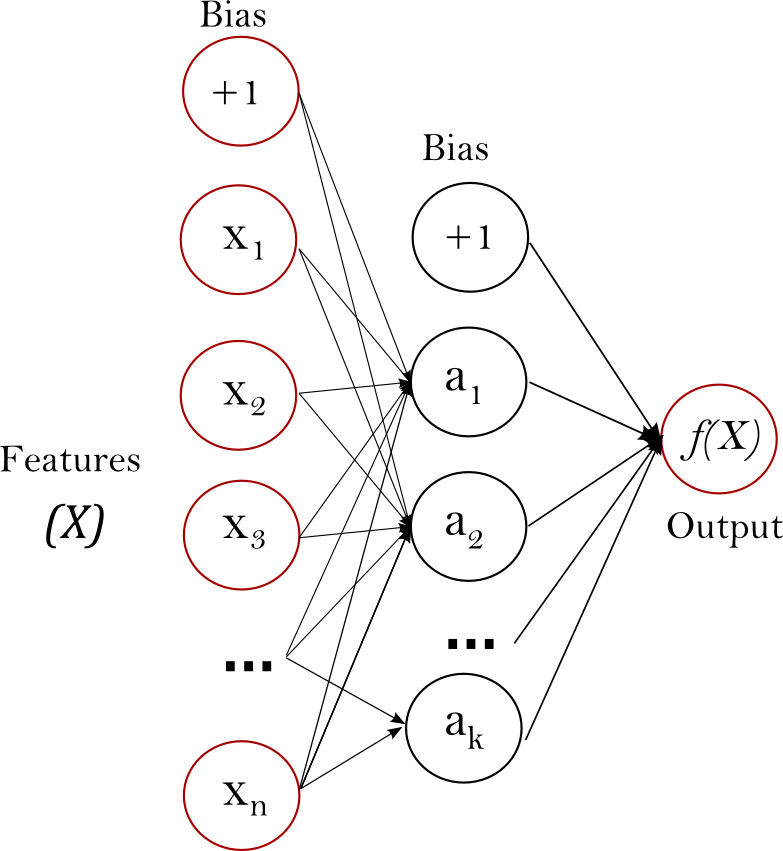

As it turns out, deep learning can achieve good performance but not best without tuning. The expense of the training procedure and the size of the model (and explainability) both count against DL and make something simpler a much better option for this problem.

**Why DL didn't have bets performance**
- Small dataset size
- Mostly linear relationships, don't need DL complexity
- Lack of DL tuning

In [93]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [100]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = None,
                        cat_cols    = [c for c in df.columns if c not in num_cols],
                        encode_cats = True,
                        verbose     = True)

X_train, y_train, X_test, y_test = _split_data(df_X, 
                                               target=TARGET, 
                                               scaler=None)


Cardinalities
ANCSTRY1                  : 255
ANCSTRY2                  : 192
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
ENGLISH                   : 5
FEB55                     : 2
HISPANIC                  : 56
IMMIGR                    : 11
INDUSTRY                  : 243
KOREAN                    : 2
LANG1                     : 2
LANG2                     : 213
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MIGPUMA                   : 109
MIGSTATE                  : 52
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OCCUP                     : 504
OTHRSERV                  : 2
PERSCARE                  : 2
POB                       : 267
POWPUMA                   : 108
POWSTATE                  : 52
RACE                      : 3
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
RVETSERV                  : 12
SC

In [101]:
# clf = MLPClassifier(random_state=1, 
#                     max_iter    =300,
#                     verbose     =True).fit(X_train, y_train)

In [103]:
# prove we can overfit to the solution
clf = MLPRegressor(
    hidden_layer_sizes = (X_train.shape[1]+1,10),
    random_state       = 1, 
    max_iter           = 10,
    learning_rate_init = 0.001,
    verbose            = True).fit(np.concatenate((X_train, y_train.reshape((-1,1))), axis=1), y_train)

Iteration 1, loss = 6596377.49699400
Iteration 2, loss = 4.71487699
Iteration 3, loss = 86.04036428
Iteration 4, loss = 182.19474518
Iteration 5, loss = 135.42114783


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [439]:
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test  = scaler.transform(X_test)

(105894, 53)

In [104]:
clf = MLPRegressor(
                hidden_layer_sizes=(X_train.shape[1],
                                    X_train.shape[1],
                                    X_train.shape[1]),
                random_state      = 1, 
                max_iter          = 300,
                learning_rate_init= 0.001,
                verbose           = False)

for i in range(100):
    clf.partial_fit(X_train, y_train)
    print(f"${np.abs(clf.predict(X_test) - y_test).mean():.2f}")

$9720.46
$9664.65
$9508.33
$9431.27
$9379.67
$9309.66
$9275.74
$9232.71
$9156.74
$9119.38
$9052.69
$9017.23
$9018.18
$8981.67
$8971.54
$8934.66
$8927.47
$8895.82
$8880.58
$8863.41
$8840.20
$8828.74
$8809.76
$8817.41
$8828.66
$8807.70
$8811.79
$8800.70
$8805.52
$8809.48
$8796.51
$8797.32
$8815.26
$8820.53
$8823.97
$8834.34
$8812.33
$8799.09
$8804.64
$8789.95
$8784.56
$8798.32
$8768.64
$8779.57
$8784.80
$8740.14
$8756.76
$8724.51
$8738.53
$8729.34
$8689.52
$8688.24
$8673.05
$8683.23
$8679.45
$8653.77
$8685.29
$8690.91
$8670.23
$8673.64
$8682.96
$8689.09
$8678.14
$8658.98
$8672.38
$8687.59
$8665.29
$8668.96
$8670.78
$8661.17
$8668.38
$8654.78
$8665.14
$8658.84
$8666.75
$8641.33
$8634.32
$8669.72
$8653.93
$8656.18
$8657.49
$8645.43
$8659.06
$8633.83
$8630.46
$8641.45
$8644.31
$8639.41
$8635.97
$8638.00
$8634.97
$8614.22


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8516.89
$8517.99


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8492.16
$8569.05


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8459.23
$8571.95


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8574.24
$8611.77


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
clf = MLPRegressor(
                hidden_layer_sizes=(X_train.shape[1],
                                    X_train.shape[1],
                                    X_train.shape[1]),
                random_state      = 1, 
                max_iter          = 300,
                learning_rate_init= 0.01,
                verbose           = False)

for i in range(100):
    clf.partial_fit(X_train, y_train)
    print(f"${np.abs(clf.predict(X_test) - y_test).mean():.2f}")

$9133.74
$10584.32
$10557.66
$10363.13
$10200.74
$9871.00
$9689.64
$9484.91
$9327.49
$9173.46
$9088.95
$9075.16
$9052.70
$9052.37
$9037.99
$8960.39
$8961.26
$9006.41
$8963.87
$8929.99
$8936.62
$8937.57
$8910.80
$8956.63
$8932.46
$8912.23
$8912.11
$8884.36
$8927.41
$8930.00
$8940.26
$8901.74
$8929.41
$8908.72
$8909.04
$8874.92
$8878.42
$8899.20
$8842.32
$8883.14
$8865.19
$8837.98
$8864.92
$8815.36
$8901.41
$8829.29
$8848.45


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8594.51
$8511.09


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8510.33
$8918.65


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8560.18
$9068.71


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8551.03
$8718.80


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$9028.86
$8708.17


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8784.73


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8759.69
$9034.62


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


$8785.40
$8747.49
$8808.68
$8862.74
$8828.01
$8800.26
$8820.79


In [465]:
# # clf = MLPRegressor(
# #     hidden_layer_sizes=(60,30),
# #     random_state=1, 
# #     max_iter=300,
# #     learning_rate_init=0.01,
# #     verbose=True).fit(X_train, y_train)

# clf = MLPRegressor(
#                 hidden_layer_sizes=(X_train.shape[1],X_train.shape[1],X_train.shape[1]),
#                 random_state=1, 
#                 max_iter=300,
#                 learning_rate_init=0.01,
#                 verbose=False)

# for i in range(100):
#     clf.partial_fit(X_train, y_train)
#     print(f"${np.abs(clf.predict(X_test) - y_test).mean():.2f}")

$9146.62
$10514.84
$10336.93
$9345.05
$8901.69
$8855.38
$8771.34
$8763.99
$8689.04
$8677.21
$8681.22
$8632.41
$8537.72
$8571.98
$8525.15
$8441.54
$8470.90
$8451.27
$8429.63
$8432.30
$8448.59
$8466.50
$8430.40
$8435.64
$8421.03
$8411.78
$8377.59
$8384.67
$8373.58
$8375.81
$8361.42
$8370.01
$8399.70
$8360.72
$8371.48
$8364.30
$8390.07
$8344.25
$8349.19
$8366.67
$8315.08
$8357.96
$8332.01
$8347.49
$8362.36
$8378.47
$8360.51
$8389.00
$8387.94
$8388.54
$8393.13
$8402.18
$8421.19
$8377.23
$8435.47
$8425.83
$8384.54
$8424.79
$8442.19
$8430.02
$8463.74
$8467.98
$8450.73
$8524.32
$8508.06
$8450.40
$8471.54
$8465.34
$8491.56
$8451.58
$8418.83
$8510.90
$8484.26
$8489.69
$8451.52
$8425.66
$8446.32
$8367.00
$8427.62
$8438.31
$8393.81
$8372.27
$8428.11
$8474.45
$8400.04
$8454.84
$8449.35
$8447.06
$8435.26
$8409.29
$8449.93
$8520.08
$8405.22
$8442.70
$8389.50
$8440.15
$8396.48
$8387.32
$8326.65
$8370.34


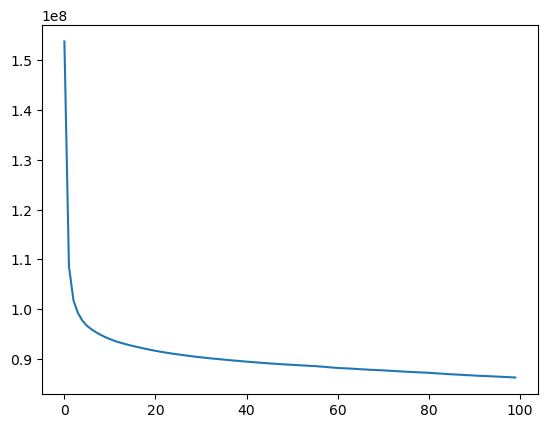

In [464]:
plt.plot(clf.loss_curve_)

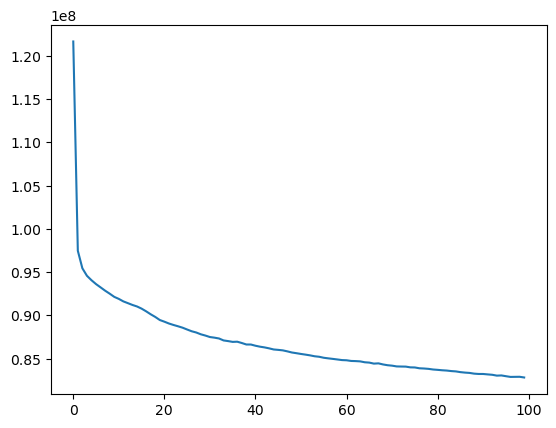

In [ ]:
# lowest loss 82M (60)
# next (60,60) -> 75M, worse test loss

In [442]:
np.abs(clf.predict(X_test) - y_test).mean()

8118.451643501429